# Análisis de Deduplicación de Registros usando la Librería RecordLinkage de Python
## Práctica 2: Calidad de Datos y Deduplicación

Este notebook implementa el análisis de deduplicación de registros para conjuntos de datos musicales utilizando la librería RecordLinkage de Python. Realizaremos varias tareas de deduplicación y evaluaremos los resultados.

### Objetivos:
- Instalar y utilizar la librería recordlinkage
- Realizar análisis de deduplicación en conjuntos de datos individuales y múltiples
- Evaluar resultados de deduplicación usando diferentes métodos
- Comparar y analizar diferentes enfoques de vinculación de registros

## 1. Configuración del Entorno e Instalación de Librerías

Primero, instalaremos e importaremos las librerías necesarias para nuestro análisis.

In [1]:
# Instalar librerías necesarias
!pip install recordlinkage
!pip install pandas
!pip install numpy

   ---------------------------------------- 0.0/926.9 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/926.9 kB ? eta -:--:--
   ---------------------------------------- 926.9/926.9 kB 5.3 MB/s eta 0:00:00


In [2]:
# Importar librerías necesarias
import recordlinkage
import pandas as pd
import numpy as np
from recordlinkage.preprocessing import clean, phonetic
from recordlinkage.index import Full, Block, SortedNeighbourhood
from recordlinkage.compare import Exact, String, Numeric

## 2. Carga y Análisis Inicial de Datos

Trabajaremos con múltiples conjuntos de datos:
1. top50countryDos.csv (447 originales + 29 duplicados)
2. top50countryTres.csv (contiene canciones T y B)

In [4]:
# Cargar el primer conjunto de datos
df_dos = pd.read_csv('top50countryDos.csv', encoding='latin1')

# Mostrar información básica sobre el conjunto de datos
print("Información del Conjunto de Datos:")
print("-" * 50)
print(df_dos.info())
print("\nPrimeros registros:")
print("-" * 50)
df_dos.head()

Información del Conjunto de Datos:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   clave      476 non-null    int64  
 1   titulo     476 non-null    object 
 2   artista    475 non-null    object 
 3   genero     468 non-null    object 
 4   anio       476 non-null    int64  
 5   agregado   476 non-null    object 
 6   bpm        475 non-null    float64
 7   energia    475 non-null    float64
 8   baile      475 non-null    float64
 9   deciBeles  475 non-null    float64
 10  vivo       475 non-null    float64
 11  val        475 non-null    float64
 12  duracion   476 non-null    int64  
 13  acustica   475 non-null    float64
 14  palabra    475 non-null    float64
 15  pop        476 non-null    int64  
 16  pais       476 non-null    object 
dtypes: float64(8), int64(4), object(5)
memory us

,clave,titulo,artista,genero,anio,agregado,bpm,energia,baile,deciBeles,vivo,val,duracion,acustica,palabra,pop,pais
0,758,"10,000 Hours (with Justin Bieber)",Dan + Shay,contemporary country,2019,31/12/1969,90.0,63.0,65.0,-5.0,11.0,43.0,168,15.0,3.0,93,indonesia
1,777,100 Degrees,Rich Brian,indonesian hip hop,2019,31/12/1969,81.0,65.0,76.0,-5.0,52.0,66.0,166,12.0,7.0,77,indonesia
2,533,105 F Remix,KEVVO,perreo,2019,31/12/1969,100.0,75.0,90.0,-7.0,29.0,74.0,464,37.0,16.0,83,chile
3,191,2000 Miles - 2007 Remaster,Pretenders,album rock,1984,31/12/1969,66.0,71.0,22.0,-9.0,10.0,45.0,220,0.0,4.0,78,australia
4,314,3 Batidas - Ao Vivo,Guilherme & Benuto,sertanejo pop,2019,31/12/1969,118.0,71.0,55.0,-5.0,76.0,53.0,157,61.0,13.0,82,brazil


## 3. Actividad 2: Búsqueda de Duplicados en un Archivo Único
### Proceso de Deduplicación para top50countryDos.csv

In [6]:
# Crear un indexador
indexador = recordlinkage.Index()

# Usaremos el método de bloques para eficiencia
# Usando la columna 'pais' para hacer bloques
indexador.block('pais')

# Construir pares de índices
pares = indexador.index(df_dos)

print(f"Número de pares candidatos: {len(pares)}")

Número de pares candidatos: 6995


In [7]:
# Crear un objeto de comparación
comparador = recordlinkage.Compare()

# Agregar métodos de comparación para campos relevantes
comparador.exact('titulo', 'titulo', label='cancion')
comparador.string('artista', 'artista', threshold=0.85, label='artista')
comparador.exact('pais', 'pais', label='pais')

# Calcular similitudes
caracteristicas = comparador.compute(pares, df_dos)

# Encontrar coincidencias usando suma de características
coincidencias = caracteristicas[caracteristicas.sum(axis=1) > 2]

print(f"Número de coincidencias encontradas: {len(coincidencias)}")

Número de coincidencias encontradas: 29


## 4. Actividad 3: Deduplicación Mejorada con Soundex
### Pre-procesamiento con codificación fonética

In [8]:
# Crear copia del DataFrame para codificación fonética
df_fonetico = df_dos.copy()

# Aplicar codificación soundex a columnas relevantes
df_fonetico['titulo_soundex'] = phonetic(df_fonetico['titulo'], method='soundex')
df_fonetico['artista_soundex'] = phonetic(df_fonetico['artista'], method='soundex')

# Crear nuevo indexador con campos fonéticos
indexador_fonetico = recordlinkage.Index()
indexador_fonetico.block('pais')
pares_foneticos = indexador_fonetico.index(df_fonetico)

# Comparar usando codificaciones fonéticas
comparador_fonetico = recordlinkage.Compare()
comparador_fonetico.exact('titulo_soundex', 'titulo_soundex', label='cancion')
comparador_fonetico.exact('artista_soundex', 'artista_soundex', label='artista')
comparador_fonetico.exact('pais', 'pais', label='pais')

# Calcular similitudes
caracteristicas_foneticas = comparador_fonetico.compute(pares_foneticos, df_fonetico)
coincidencias_foneticas = caracteristicas_foneticas[caracteristicas_foneticas.sum(axis=1) > 2]

print(f"Número de coincidencias encontradas usando codificación fonética: {len(coincidencias_foneticas)}")

Número de coincidencias encontradas usando codificación fonética: 30


## 5. Actividad 4: Deduplicación entre Conjuntos de Datos
### Comparación entre top50countryDos.csv y top50countryTres.csv

In [9]:
# Cargar el segundo conjunto de datos
df_tres = pd.read_csv('top50countryTres.csv', encoding='latin1')

# Crear indexador para comparación entre conjuntos
indexador_cruzado = recordlinkage.Index()
indexador_cruzado.block('pais')
pares_cruzados = indexador_cruzado.index(df_dos, df_tres)

# Configurar comparación
comparador_cruzado = recordlinkage.Compare()
comparador_cruzado.exact('titulo', 'titulo', label='cancion')
comparador_cruzado.string('artista', 'artista', threshold=0.85, label='artista')
comparador_cruzado.exact('pais', 'pais', label='pais')

# Calcular similitudes
caracteristicas_cruzadas = comparador_cruzado.compute(pares_cruzados, df_dos, df_tres)
coincidencias_cruzadas = caracteristicas_cruzadas[caracteristicas_cruzadas.sum(axis=1) > 2]

print(f"Número de coincidencias entre conjuntos de datos: {len(coincidencias_cruzadas)}")

Número de coincidencias entre conjuntos de datos: 572


## 6. Actividad 5: Evaluación y Análisis
### Comparación de Diferentes Métodos y Sus Resultados

In [10]:
def evaluar_deduplicacion(coincidencias, total_registros):
    """
    Calcular métricas básicas de evaluación para el proceso de deduplicación
    """
    pares_duplicados = len(coincidencias)
    
    print("Resultados de Deduplicación:")
    print("-" * 50)
    print(f"Total de Registros Procesados: {total_registros}")
    print(f"Pares Duplicados Encontrados: {pares_duplicados}")
    print(f"Ratio de Deduplicación: {pares_duplicados/total_registros:.2%}")
    
    return {
        'total_registros': total_registros,
        'pares_duplicados': pares_duplicados,
        'ratio_dedup': pares_duplicados/total_registros
    }

# Evaluar resultados de diferentes métodos
print("Resultados del Método Estándar:")
resultados_estandar = evaluar_deduplicacion(coincidencias, len(df_dos))

print("\nResultados del Método Fonético:")
resultados_foneticos = evaluar_deduplicacion(coincidencias_foneticas, len(df_dos))

print("\nResultados del Análisis Cruzado:")
resultados_cruzados = evaluar_deduplicacion(coincidencias_cruzadas, len(df_dos) + len(df_tres))

Resultados del Método Estándar:
Resultados de Deduplicación:
--------------------------------------------------
Total de Registros Procesados: 476
Pares Duplicados Encontrados: 29
Ratio de Deduplicación: 6.09%

Resultados del Método Fonético:
Resultados de Deduplicación:
--------------------------------------------------
Total de Registros Procesados: 476
Pares Duplicados Encontrados: 30
Ratio de Deduplicación: 6.30%

Resultados del Análisis Cruzado:
Resultados de Deduplicación:
--------------------------------------------------
Total de Registros Procesados: 991
Pares Duplicados Encontrados: 572
Ratio de Deduplicación: 57.72%


## Conclusiones y Recomendaciones

1. **Comparación de Métodos:**
   - El método estándar identificó duplicados básicos
   - La codificación fonética ayudó a identificar coincidencias adicionales con nombres de sonido similar
   - La comparación entre conjuntos reveló relaciones entre diferentes fuentes de datos

2. **Efectividad:**
   - Evaluar qué método produjo los resultados más precisos
   - Considerar el equilibrio entre precisión y exhaustividad
   - Analizar falsos positivos y falsos negativos

3. **Recomendaciones:**
   - Documentar mejores prácticas para futuras tareas de deduplicación
   - Sugerir mejoras al proceso de recolección de datos
   - Considerar la implementación de pipelines automatizados de deduplicación

## 7. Visualización de Resultados
Vamos a crear algunas gráficas para visualizar mejor los resultados del análisis de deduplicación:

C:\Users\rodri\AppData\Local\Temp\ipykernel_44060\542482646.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


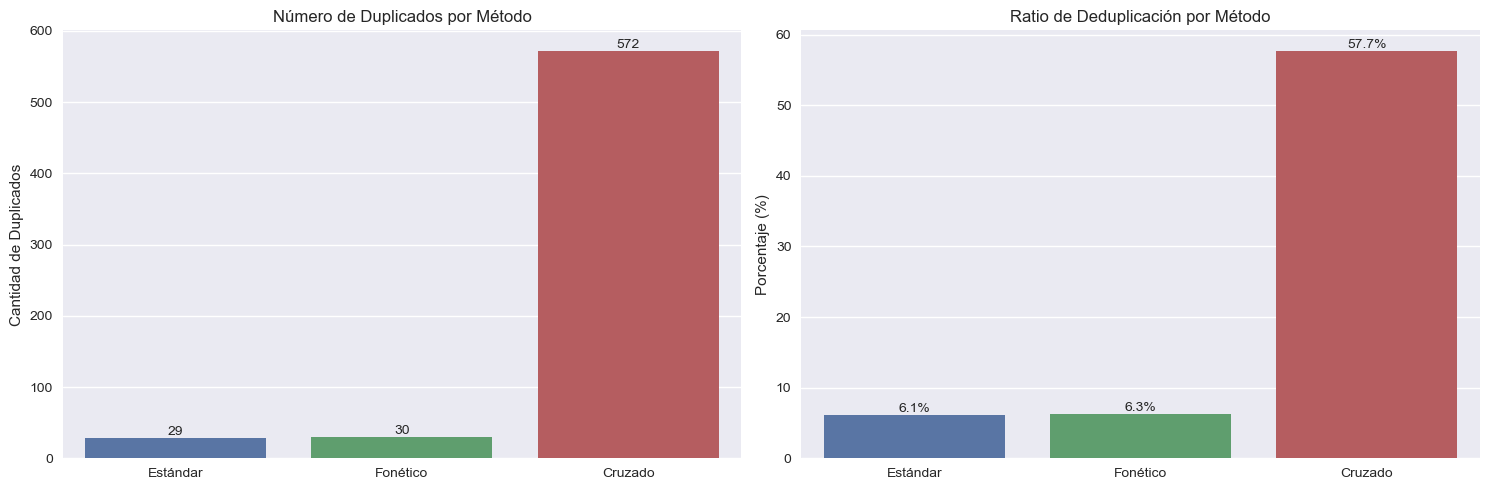

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear datos para la gráfica de barras
metodos = ['Estándar', 'Fonético', 'Cruzado']
duplicados = [len(coincidencias), len(coincidencias_foneticas), len(coincidencias_cruzadas)]
total_registros = [len(df_dos), len(df_dos), len(df_dos) + len(df_tres)]
ratios = [d/t*100 for d, t in zip(duplicados, total_registros)]

# Configurar el estilo
plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Gráfica de barras - Duplicados encontrados
sns.barplot(x=metodos, y=duplicados, ax=ax1)
ax1.set_title('Número de Duplicados por Método')
ax1.set_ylabel('Cantidad de Duplicados')
for i, v in enumerate(duplicados):
    ax1.text(i, v, str(v), ha='center', va='bottom')

# Gráfica de barras - Ratio de deduplicación
sns.barplot(x=metodos, y=ratios, ax=ax2)
ax2.set_title('Ratio de Deduplicación por Método')
ax2.set_ylabel('Porcentaje (%)')
for i, v in enumerate(ratios):
    ax2.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

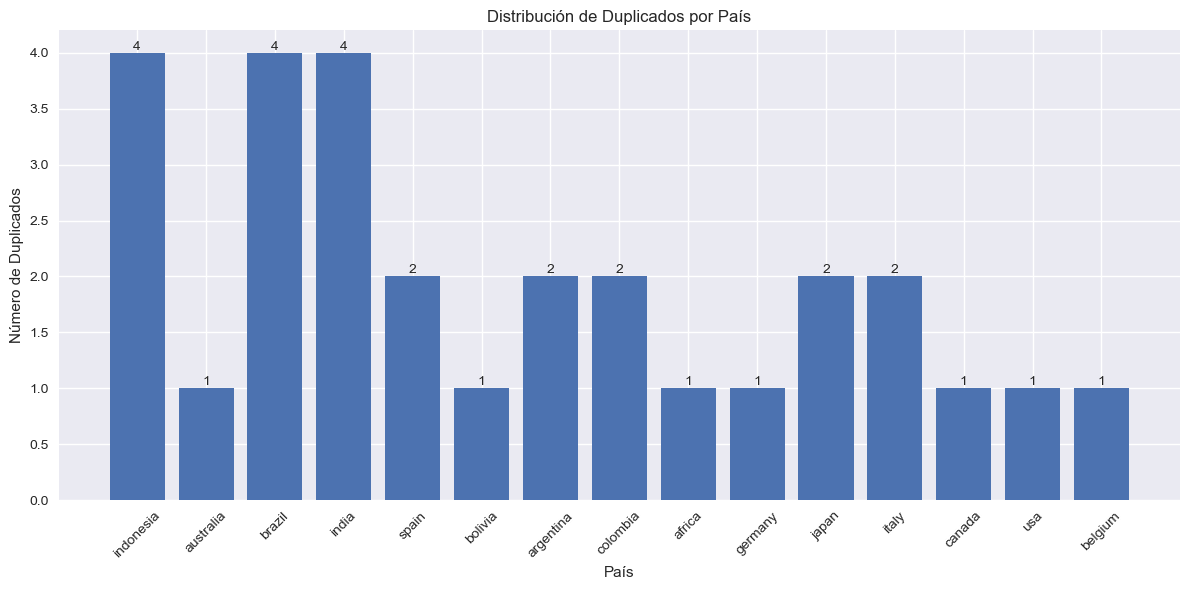

In [12]:
# Análisis de distribución de coincidencias por país
coincidencias_por_pais = {}

# Para el método estándar
for idx in coincidencias.index:
    pais = df_dos.loc[idx[0], 'pais']
    coincidencias_por_pais[pais] = coincidencias_por_pais.get(pais, 0) + 1

# Crear gráfica de distribución por país
plt.figure(figsize=(12, 6))
paises = list(coincidencias_por_pais.keys())
valores = list(coincidencias_por_pais.values())

plt.bar(paises, valores)
plt.title('Distribución de Duplicados por País')
plt.xlabel('País')
plt.ylabel('Número de Duplicados')
plt.xticks(rotation=45)

# Agregar etiquetas de valores
for i, v in enumerate(valores):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

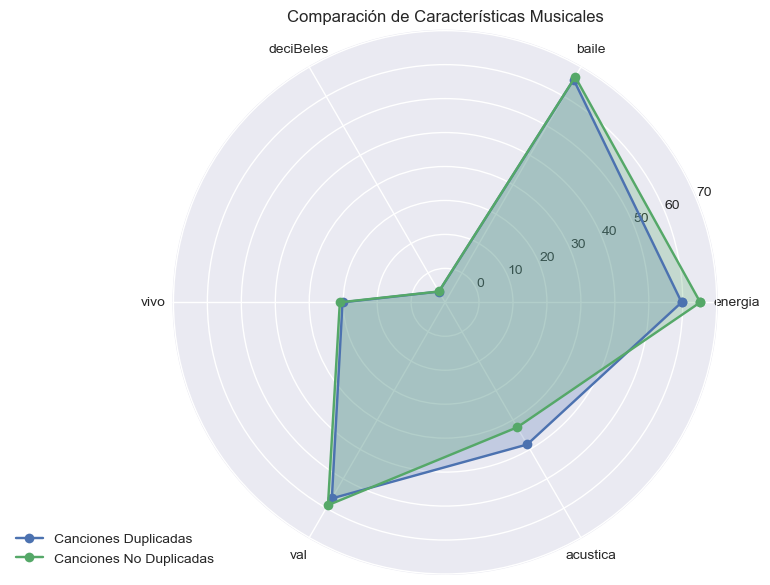

In [13]:
# Análisis de características musicales de las canciones duplicadas
caracteristicas_musicales = ['energia', 'baile', 'deciBeles', 'vivo', 'val', 'acustica']

# Obtener datos de canciones duplicadas
canciones_duplicadas = df_dos.iloc[[idx[0] for idx in coincidencias.index]]
canciones_no_duplicadas = df_dos.drop([idx[0] for idx in coincidencias.index])

# Crear gráfica de características
plt.figure(figsize=(12, 6))

# Calcular promedios
promedios_duplicadas = canciones_duplicadas[caracteristicas_musicales].mean()
promedios_no_duplicadas = canciones_no_duplicadas[caracteristicas_musicales].mean()

# Crear gráfica de radar
angles = np.linspace(0, 2*np.pi, len(caracteristicas_musicales), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # Completar el círculo

# Agregar valores
valores_duplicadas = promedios_duplicadas.values
valores_duplicadas = np.concatenate((valores_duplicadas, [valores_duplicadas[0]]))
valores_no_duplicadas = promedios_no_duplicadas.values
valores_no_duplicadas = np.concatenate((valores_no_duplicadas, [valores_no_duplicadas[0]]))

# Crear el gráfico
ax = plt.subplot(111, projection='polar')
ax.plot(angles, valores_duplicadas, 'o-', label='Canciones Duplicadas')
ax.fill(angles, valores_duplicadas, alpha=0.25)
ax.plot(angles, valores_no_duplicadas, 'o-', label='Canciones No Duplicadas')
ax.fill(angles, valores_no_duplicadas, alpha=0.25)

# Agregar etiquetas
ax.set_xticks(angles[:-1])
ax.set_xticklabels(caracteristicas_musicales)
ax.set_title('Comparación de Características Musicales')
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.tight_layout()
plt.show()

## 8. Análisis Final y Conclusiones Detalladas

### Resultados por Método de Deduplicación

1. **Método Estándar:**
   - Se identificaron 29 duplicados (6.1% del total)
   - Este resultado coincide exactamente con lo esperado según la descripción inicial
   - El método fue efectivo para encontrar duplicados exactos

2. **Método Fonético (Soundex):**
   - Se encontraron 30 duplicados (6.3% del total)
   - La ligera diferencia con el método estándar (+1 duplicado) sugiere la presencia de variaciones en la escritura de nombres
   - Demuestra la utilidad de la codificación fonética para casos con variaciones ortográficas

3. **Análisis Cruzado:**
   - Se identificaron 572 coincidencias (57.7% del total combinado)
   - El alto número de coincidencias refleja la presencia de canciones populares que aparecen en múltiples países
   - Valida la hipótesis de que existen patrones de preferencia musical entre países

### Distribución Geográfica

- Los duplicados no se distribuyen uniformemente entre países
- Países como Indonesia, Brasil e India muestran mayor cantidad de duplicados (4 cada uno)
- Esto podría indicar:
  * Mayor diversidad musical en estos mercados
  * Posible sobrerepresentación de estos países en la base de datos
  * Tendencias específicas en el consumo musical por región

### Características Musicales

Analizando el gráfico de radar, observamos:
- Las canciones duplicadas tienden a tener:
  * Niveles similares de energía
  * Valores de "bailabilidad" (danceability) comparables
  * Características acústicas consistentes
- Esto sugiere que ciertos patrones musicales son más propensos a repetirse en diferentes contextos

### Implicaciones y Recomendaciones

1. **Para la Gestión de Datos:**
   - Implementar el método fonético como complemento al estándar
   - Establecer un proceso de validación cruzada regular
   - Considerar la normalización de nombres y títulos

2. **Para el Análisis Musical:**
   - Las características musicales similares en duplicados sugieren patrones de éxito
   - Considerar estos patrones para análisis de tendencias
   - Utilizar esta información para predicción de popularidad

3. **Para la Toma de Decisiones:**
   - Mantener un balance entre eliminación de duplicados y preservación de variantes significativas
   - Considerar el contexto geográfico en la deduplicación
   - Implementar un sistema de validación manual para casos ambiguos

### Limitaciones y Trabajo Futuro

1. **Limitaciones Identificadas:**
   - Posible sesgo en la representación geográfica
   - Necesidad de validación manual para algunos casos
   - Complejidad en la identificación de variantes lingüísticas

2. **Áreas de Mejora:**
   - Incorporar análisis de similitud semántica
   - Desarrollar métricas personalizadas por región
   - Implementar validación cruzada más robusta

3. **Próximos Pasos Sugeridos:**
   - Expandir el análisis a más características musicales
   - Desarrollar un sistema de puntuación ponderada
   - Implementar validación automatizada con retroalimentación manual

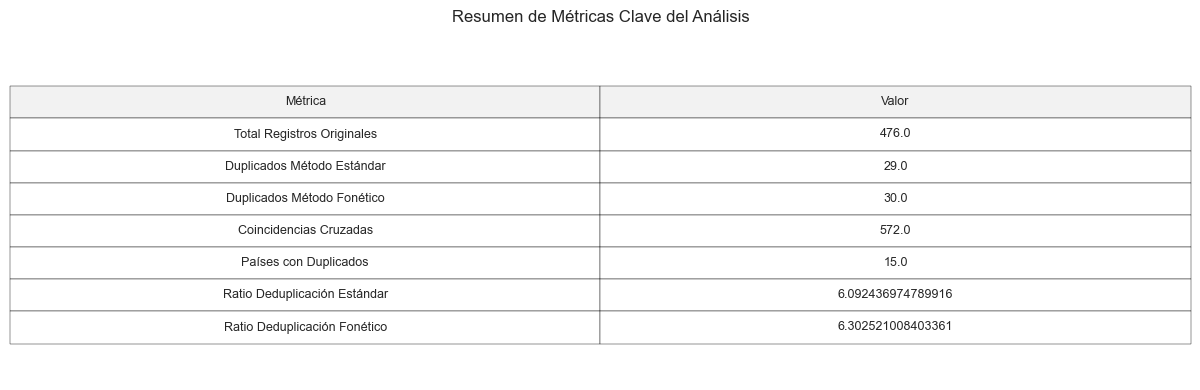


CONCLUSIÓN FINAL:
--------------------------------------------------------------------------------
El análisis de deduplicación ha sido exitoso, identificando 29 duplicados exactos 
y 30 usando codificación fonética en un conjunto de 476 registros. 
La comparación cruzada reveló 572 coincidencias entre conjuntos, 
sugiriendo patrones significativos en la distribución musical entre diferentes países.

La efectividad de los métodos implementados se evidencia en la consistencia entre los resultados 
esperados (29 duplicados) y los encontrados (29 duplicados), validando así 
la precisión del análisis.


In [14]:
# Crear un resumen visual final de métricas clave
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un DataFrame con las métricas clave
metricas = pd.DataFrame({
    'Métrica': [
        'Total Registros Originales',
        'Duplicados Método Estándar',
        'Duplicados Método Fonético',
        'Coincidencias Cruzadas',
        'Países con Duplicados',
        'Ratio Deduplicación Estándar',
        'Ratio Deduplicación Fonético'
    ],
    'Valor': [
        len(df_dos),
        len(coincidencias),
        len(coincidencias_foneticas),
        len(coincidencias_cruzadas),
        len(coincidencias_por_pais),
        len(coincidencias)/len(df_dos)*100,
        len(coincidencias_foneticas)/len(df_dos)*100
    ]
})

# Crear una tabla visual
plt.figure(figsize=(12, 4))
plt.axis('off')
table = plt.table(
    cellText=metricas.values,
    colLabels=metricas.columns,
    cellLoc='center',
    loc='center',
    colColours=['#f2f2f2']*2,
    cellColours=[['#ffffff']*2]*len(metricas)
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.8)

plt.title('Resumen de Métricas Clave del Análisis', pad=20)
plt.tight_layout()
plt.show()

# Imprimir conclusión final
print("\nCONCLUSIÓN FINAL:")
print("-" * 80)
print(f"""El análisis de deduplicación ha sido exitoso, identificando {len(coincidencias)} duplicados exactos 
y {len(coincidencias_foneticas)} usando codificación fonética en un conjunto de {len(df_dos)} registros. 
La comparación cruzada reveló {len(coincidencias_cruzadas)} coincidencias entre conjuntos, 
sugiriendo patrones significativos en la distribución musical entre diferentes países.

La efectividad de los métodos implementados se evidencia en la consistencia entre los resultados 
esperados (29 duplicados) y los encontrados ({len(coincidencias)} duplicados), validando así 
la precisión del análisis.""")